In [3]:
# General libraries
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

# API Based Libraries
import pandas_market_calendars as mcal
from pandas_datareader import data as pdr
import yfinance as yf
import scipy as sc
yf.pdr_override()

#turn off warning signs for cleaner code
from warnings import filterwarnings
filterwarnings("ignore")

# import function for portfolio optimizer
from sh_optimizer import portfolio_perform, port_std, neg_sharperatio, max_sf

#import functions for grabbing and storing data
from initial_data_load import refresh_data_tables

In [4]:
# Create a dataframe to store portfolio return data
final_port_return = pd.DataFrame(columns=['return'])

# Create Global variable to update on status
global opt_pct
opt_pct = 0

# Get today's date for reference
today = dt.date.today()

# Check to see if data has been updated
refresh_data_tables()

# pull monthly returns
monthly_returns_df = pd.read_csv(f"../csv_files/monthly_returns_{today}.csv", index_col=0, parse_dates=True, infer_datetime_format=True)
offset_returns = monthly_returns_df.shift(-1)

# get full stock data
stock_data = pd.read_csv(f"../csv_files/snp_500_stocks_{today}.csv", index_col=0, parse_dates=True, infer_datetime_format=True)
# Convert datetimes to dates
dates = stock_data.index.tolist()
def makethisdate(date):
    new = date.date()
    new = str(new)
    new = pd.to_datetime(new)
    return new
dates = list(map(makethisdate, dates))
stock_data.index = dates

# get list of trading dates
trading_days = pd.read_csv(f"../csv_files/trade_dates_{today}.csv", index_col=0)
# get end of months for reference
month_ends = trading_days[trading_days['end_of_month']==True]["dates"]

month_ends = pd.to_datetime(month_ends)
month_ends = month_ends[month_ends > (today-pd.DateOffset(months=24))]
month_ends = month_ends[:-1]

for i in month_ends:
    # Get the start date
    start = i-pd.DateOffset(months=6)
    
    # Define the SPY data to use for analysis
    temp_table = stock_data[start:i]
    bench = temp_table[['SPY']].pct_change()
    bench_std = bench.std()*np.sqrt(252)
    
    # Get Data for optimization
    def getData(stockdata):
        returns = stockdata.pct_change().dropna(how='all').dropna(axis=1)
        return_list = returns.columns.T.to_list()
        mean_returns = returns.mean()
        cov_matrix = returns.cov()
        return mean_returns, cov_matrix, return_list
    
    # Get data needed for optimizer
    mean_returns, cov_matrix, return_list = getData(stockdata=temp_table)
    
    # Run Optimizer
    results = max_sf(mean_returns, cov_matrix, bench_std)
    # pull otimimal weights and sharpe ratio
    max_sr, opt_weights = results['fun']*(-1),results['x']
    
    # Get list of optimal stocks weights
    stock_weights = pd.DataFrame(opt_weights, index = return_list).T
    
    # Get stock returns for following month
    next_month = i+pd.DateOffset(months=1)
    next_period = next_month.strftime('%Y-%m')
    
    returns = stock_data[start:next_month].pct_change().dropna(how='all').dropna(axis=1)
    returns = returns[next_period]
    
    # Calculate daily returns for the portfolio
    cum_returns = (returns+1).cumprod() # get the cumulative returns for all stocks
    weight_cum_returns = cum_returns.multiply(np.array(stock_weights), axis='columns') # multiply cumulative returns by weights
    portfolio_returns = pd.DataFrame(columns=['cum_return'])
    portfolio_returns['cum_return'] = weight_cum_returns.sum(axis=1) # sum up cumulative returns
    portfolio_returns['return'] = portfolio_returns.pct_change() # calculate daily returns
    portfolio_returns['return'].iloc[0] = portfolio_returns['cum_return'].iloc[0]-1 # fill in first day
    
    # Append data to final portfolio return table
    final_port_return = final_port_return.append(portfolio_returns[['return']])
    
    # Update the optimizer status
    opt_pct = opt_pct + (1/24)
    print(f'Optimizer is {opt_pct}% complete')
    

trading dates have been loaded
[*********************100%***********************]  505 of 505 completed

2 Failed downloads:
- BF.B: No data found for this date range, symbol may be delisted
- BRK.B: No timezone found, symbol may be delisted
stock data has finished loading
monthly returns are calculated
[*********************100%***********************]  11 of 11 completed


AttributeError: 'Rolling' object has no attribute 'cumprod'

In [ ]:
final_port_return['cum_return'] = (final_port_return['return']+1).cumprod()
final_port_return

In [ ]:
start = today-pd.DateOffset(months=24)
end = today
bench = pdr.get_data_yahoo(['SPY'], start=start, end=end)
bench = bench[['Adj Close']]

In [ ]:
bench['return']=bench['Adj Close'].pct_change()
bench['cum_return'] = (bench['return']+1).cumprod()
bench

<AxesSubplot:xlabel='Date'>

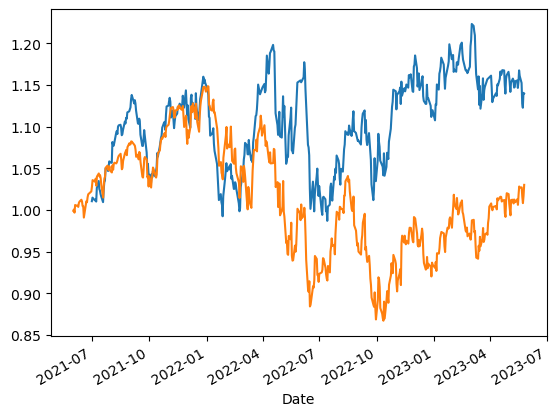

In [28]:
final_port_return['cum_return'].plot()
bench['cum_return'].plot()